Libraries:

In [127]:
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import random
from random import randrange

Needed columns:

* product name
* customers
* unit price
* elasticity
* units
* total (revenue)
* date

Additional requirements:
* price ranges should be within 5 and 95 percentiles of prices in training data
* quantity ranges should be within 5 and 95 percentiles of quantities in training data
* products number should be adjustable
* number of transaction for each product should be adjustable
* number of customers for each product should be adjustable
* we can test multiple elastities for each given product


Define percentiles:
* p_05 = train_data['Price'].quantile(0.05)
* p_95 = train_data['Price'].quantile(0.95) <br/> <br/>
* q_05 = train_data['Quantity'].quantile(0.05)
* q_95 = train_data['Quantity'].quantile(0.95)

Inputs:

In [185]:
p_05 = 24    # 5% percentile of prices in train data
p_95 = 7500  # 95% percentile of prices in train data

q_05 = 1     # 5% percentile of quantities in train data
q_95 = 200   # 95% percentile of quantities in train data

p_n = 10     # number of products in test data
t_n = 100    # number of transactions for each product in test data
c_n = 45     #number of customers in test data

e = [-1, 0, 1] #list of elastisities to test with each product

In [186]:
column_namings = {'price_col': 'Price',
                 'prod_name_col': 'Product',
                 'elasticity_col':'Elasticity',
                 'quantity_col': 'Quantity',
                 'revenue_col': 'Total',
                 'customer_col': 'Customer',
                 'date_col': 'Date',
                 'year_col':'Year',
          }

In [187]:
def date_list(lst, n):
        '''
        Slice list into n sublists, sort them, merge again and return a single list
        '''
        sublists = [lst[i:i + n] for i in range(0, len(lst), n)]
        sublists = [sorted([datetime.strptime(date, '%d/%m/%Y').date()
                           for date in sublist]) for sublist in sublists]
        sorted_list = [str(date.strftime('%d/%m/%Y'))
                       for sublist in sublists for date in sublist]
        return sorted_list
    
    
def random_date(start, end):
        '''
        This function will return a random datetime between two datetime 
        objects.
        '''
        delta = end - start
        int_delta = (delta.days * 24 * 60 * 60)  # + delta.seconds
        random_second = randrange(int_delta)
        return start + timedelta(seconds=random_second)

In [188]:
data_brands = [
            {'Brand': 'Air Defence Show',
             'Currency': 'UAH',
             'Brand country': 'Ukraine',
             'Brand market': 'Public admin, defence & social security',
             },

            {'Brand': 'Best Tanks Show',
             'Currency': 'USD',
             'Brand country': 'USA',
             'Brand market': 'Public admin, defence & social security',
             }
]


In [189]:
def create_test_data(price_5_percentile, 
                     price_95_percentile, 
                     quantity_5_percentile, 
                     quantity_95_percentile, 
                     n_products,
                     n_transactions,
                     n_customers,
                     elasticity,
                     start_date,
                     end_date

                                        ):
    '''
    price_5_percentile - 5% percentile of prices in train data
    price_95_percentile - 95% percentile of prices in train data
    quantity_5_percentile - 5% percentile of quantities in train data
    quantity_95_percentile - 95% percentile of quantities in train data
    n_products - number of products in test data
    n_transactions - number of transactions for each product in test data
    n_customers - number of customers in test data
    elasticity - list of elastisities to test with each product
    start_date
    end_date
    
    '''
    
    price_growth = price_95_percentile/price_5_percentile
    
    # we want to show prices in dynamic to reflect changes in demand according to predefined elasticity 
    # we want products to differ, for this we need unique start price for each product 
    # multiplicator is needed to grow price from 0.5 percentile to 0.95 percentile in n steps (n = n_products)
    #each step will help to define the start price for each next product
    p_step = price_growth**(1 / n_products)
    
    #creating start prices list
    p = [p_05]
    p = [p[0] * p_step ** i for i in range(n_products)]
    
    # removing last price to avoid testing prices higher than 0.95 percentile
    p = np.round(p)[:-1]
    
    #we will use the same logic to get start quantities list
    quantity_growth = q_95 / q_05
    q_step = quantity_growth**(1 / n_products)
    q = [q_05]
    q = [q[0] * q_step ** i for i in range(n_products)]
    q = np.round(q)[:-1]
    q = [i for i in q.tolist() if i < q_95]
    q = sorted(q, reverse=True)
    
    df = pd.DataFrame()

    for e in elasticity:
        for n in range(n_products - 1):
            #calculating what price change should be used as a step for each transaction
            pct_q = ((q_95 / q[n])**(1 / (n_transactions - 1)) - 1) / 2
            pct_p = ((p_95 / p[n])**(1 / (n_transactions - 1))) - 1
            pct = min(pct_q, pct_p)
            
            df_prod = pd.DataFrame(index=range(n_transactions))
            df_prod[column_namings['prod_name_col']] = f'Product_{n+1}'
            df_prod[column_namings['elasticity_col']] = e
            
            # creating pairs quantity-price for n products
            sales = [[p[n] * (1 + pct)**i, q[n] * (1 + pct * e)**i]
                         for i
                         in range(n_transactions)
                         ]
            
            pq = pd.DataFrame(sales, 
                              columns=[column_namings['price_col'], 
                                       column_namings['quantity_col']])
            
            df_prod = df_prod.join(pq)
            df = pd.concat([df, df_prod])
        df = df.reset_index(drop=True)
        
        # adding revenue column
        df[column_namings['revenue_col']] = df[column_namings['quantity_col']] * df[column_namings['price_col']]
        
    # adding customer columns
    #customer will be picked randomly for each transaction
    customer_list = [f'Tester_{i}' for i in range(n_customers)]
    list_of_customers = [random.choice(customer_list) for _ in range(len(df))]
    df[column_namings['customer_col']] = list_of_customers
    
    # adding date column
    #dates are being choosed randomly in range from start_date to end_date with reasonable step

    d1 = datetime.strptime(start_date, '%d/%m/%Y')
    d2 = datetime.strptime(end_date, '%d/%m/%Y')
    
    dates_list = []
    dates_list = [random_date(d1, d2).strftime('%d/%m/%Y') 
                  for _ 
                  in range((n_products -1) * 
                        n_transactions * 
                        len(elasticity))]
    dates_list = date_list(dates_list, n_transactions)
    df[column_namings['date_col']] = dates_list
    df[column_namings['date_col']]  = pd.to_datetime(df[column_namings['date_col']] , format='%d/%m/%Y')
    
    df[column_namings['year_col']] = df[column_namings['date_col']].dt.year

    #if quantity is calculated below 0, we want to replace it with 1
    df.loc[df[column_namings['quantity_col']] <
               1, column_namings['quantity_col']] = 1
    
    result = pd.DataFrame()
    #in case we want to test impact of country or currency column on prediction
    #so need to add different brands
    for d in data_brands:
        for k, v in d.items():
            df[k] = v
        result = pd.concat([result, df])
            
    result = result.reset_index(drop=True)


        
    return result
    
 

In [196]:
test_data = create_test_data(p_05, p_95, q_05, q_95, p_n, t_n,c_n, e, '1/1/2014','1/1/2022' )

In [199]:
test_data.sample(5)

,Product,Elasticity,Price,Quantity,Total,Customer,Date,Year,Brand,Currency,Brand country,Brand market
437,Product_5,-1,438.280787,4.318643,1892.778220,Tester_17,2017-04-09,2017,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
613,Product_7,-1,996.306212,2.256569,2248.233971,Tester_43,2015-06-14,2015,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
283,Product_3,-1,185.729143,9.725713,1806.348341,Tester_33,2020-11-15,2020,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
4045,Product_5,0,499.682285,8.000000,3997.458278,Tester_20,2018-01-10,2018,Best Tanks Show,USD,USA,"Public admin, defence & social security"
733,Product_8,-1,2376.791926,1.114482,2648.892015,Tester_18,2016-09-15,2016,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"


In [200]:
test_data[test_data['Product'] == 'Product_1']

,Product,Elasticity,Price,Quantity,Total,Customer,Date,Year,Brand,Currency,Brand country,Brand market
0,Product_1,-1,24.000000,69.000000,1656.000000,Tester_10,2014-01-17,2014,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
1,Product_1,-1,24.129691,68.627138,1655.951643,Tester_12,2014-01-31,2014,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
2,Product_1,-1,24.260083,68.256291,1655.903288,Tester_6,2014-03-02,2014,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
3,Product_1,-1,24.391179,67.887448,1655.854934,Tester_16,2014-04-11,2014,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
4,Product_1,-1,24.522984,67.520598,1655.806581,Tester_44,2014-04-14,2014,Air Defence Show,UAH,Ukraine,"Public admin, defence & social security"
...,...,...,...,...,...,...,...,...,...,...,...,...
4595,Product_1,1,40.046138,115.132648,4610.617950,Tester_23,2021-08-13,2021,Best Tanks Show,USD,USA,"Public admin, defence & social security"
4596,Product_1,1,40.262539,115.754801,4660.582249,Tester_13,2021-10-26,2021,Best Tanks Show,USD,USA,"Public admin, defence & social security"
4597,Product_1,1,40.480110,116.380316,4711.088002,Tester_30,2021-11-17,2021,Best Tanks Show,USD,USA,"Public admin, defence & social security"
4598,Product_1,1,40.698856,117.009212,4762.141074,Tester_14,2021-11-19,2021,Best Tanks Show,USD,USA,"Public admin, defence & social security"


array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Quantity'}>]], dtype=object)

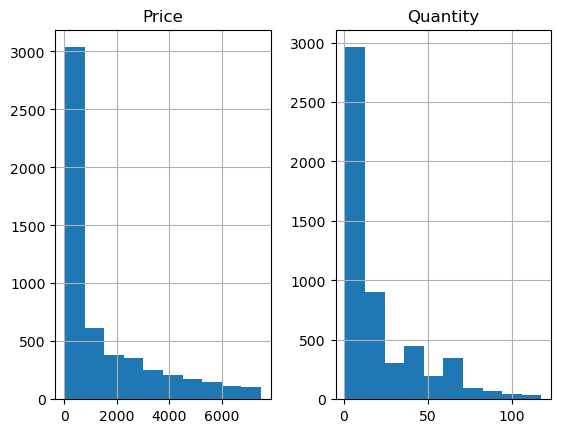

In [201]:
test_data[['Price','Quantity']].hist()

In [194]:
f.groupby(['Brand', 'Brand market','Brand country', 'Currency','Product', 'Elasticity'])[['Price', 'Quantity']].apply(lambda x: x.pct_change().mean()).reset_index().fillna(0)

,Brand,Brand market,Brand country,Currency,Product,Elasticity,Price,Quantity
0,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_1,-1,0.005404,-0.005404
1,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_1,0,0.005404,0.000000
2,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_1,1,0.005404,0.005404
3,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_2,-1,0.008068,-0.008068
4,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_2,0,0.008068,0.000000
5,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_2,1,0.008068,0.008068
6,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_3,-1,0.010824,-0.010824
7,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_3,0,0.010824,0.000000
8,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_3,1,0.010824,0.010824
9,Air Defence Show,"Public admin, defence & social security",Ukraine,UAH,Product_4,-1,0.013613,-0.013613
